## Bayesian Neural Networks in Keras and TensorFlow 2.0

In [22]:
#! . activate base
#!pip install tensorflow==2.0.0b1 --user
#!pip install tfp_nightly --user
#!python -m ipykernel install --name tf_prob --user

In [1]:
#TODO: PUT RANDOM SEED FOR RESULT SECURING IN DEMOS
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2

%matplotlib inline

/home/u30073/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/u30073/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/u30073/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/u30073/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

In [2]:
print('TensorFlow version (expected = 2.0.0-beta1):', tf.__version__)
print('TensorFlow Probability version (expected = 0.9.0-dev20190912):', tfp.__version__)

TensorFlow version (expected = 2.0.0-beta1): 2.0.0-beta1
TensorFlow Probability version (expected = 0.9.0-dev20190912): 0.9.0-dev20190913


In [3]:
def softmax(X, theta = 1.0, axis = None):
    """
    Compute the softmax of each element along an axis of X.

    Parameters
    ----------
    X: ND-Array. Probably should be floats.
    theta (optional): float parameter, used as a multiplier
        prior to exponentiation. Default = 1.0
    axis (optional): axis to compute values along. Default is the
        first non-singleton axis.

    Returns an array the same size as X. The result will sum to 1
    along the specified axis.
    """

    # make X at least 2d
    y = np.atleast_2d(X)

    # find axis
    if axis is None:
        axis = next(j[0] for j in enumerate(y.shape) if j[1] > 1)

    # multiply y against the theta parameter,
    y = y * float(theta)

    # subtract the max for numerical stability
    y = y - np.expand_dims(np.max(y, axis = axis), axis)

    # exponentiate y
    y = np.exp(y)

    # take the sum along the specified axis
    ax_sum = np.expand_dims(np.sum(y, axis = axis), axis)

    # finally: divide elementwise
    p = y / ax_sum

    # flatten if X was 1D
    if len(X.shape) == 1: p = p.flatten()

    return p

## We are all set up, lets go!

We are using CIFAR10 dataset!
X_train.shape = (50000, 32, 32, 3)
y_train.shape = (50000, 10)
X_test.shape = (10000, 32, 32, 3)
y_test.shape = (10000, 10)


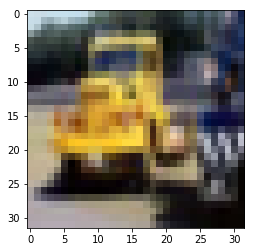

In [4]:
"""
first, we load the dataset. We are trying to do it first with CIFAR
I've found this snippet somewhere in github
"""

#as we have 10 classes, I'm setting class number to 10
class_nmr = 10

print('We are using CIFAR10 dataset!')
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
#X_train = np.expand_dims(X_train, -1)
n_train = X_train.shape[0]
#X_test = np.expand_dims(X_test, -1)
y_train = tf.keras.utils.to_categorical(y_train, class_nmr)
y_test = tf.keras.utils.to_categorical(y_test, class_nmr)

# Normalize data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print("X_train.shape =", X_train.shape)
print("y_train.shape =", y_train.shape)
print("X_test.shape =", X_test.shape)
print("y_test.shape =", y_test.shape)

plt.imshow(X_train[1026, :, :, :])

In [5]:
def build_bayesian_bcnn_model(input_shape):
    
    """
    Here we use tf.keras.Model to use our graph as a Neural Network:
    We select our input node as the net input, and the last node as our output (predict node).
    Note that our model won't be compiled, as we are usign TF2.0 and will optimize it with
    a custom @tf.function for loss and a @tf.function for train_step
    Our input parameter is just the input shape, a tuple, for the input layer
    """
    
    model_in = tf.keras.layers.Input(shape=input_shape)
    
    conv_1 = tfp.python.layers.Convolution2DFlipout(32, kernel_size=(3, 3), padding="same", strides=2)
    x = conv_1(model_in)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    conv_2 = tfp.python.layers.Convolution2DFlipout(32, kernel_size=(3, 3), padding="same", strides=2)
    x = conv_2(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, padding='SAME', data_format='channels_last')(x)
    x = tf.keras.layers.Dropout(rate=0.2)(x)

    
    conv_3 = tfp.python.layers.Convolution2DFlipout(64, kernel_size=(3, 3), padding="same", strides=2)
    x = conv_3(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, padding='SAME', data_format='channels_last')(x)
    
    conv_4 = tfp.python.layers.Convolution2DFlipout(64, kernel_size=(3, 3), padding="same", strides=2)
    x = conv_4(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, padding='SAME', data_format='channels_last')(x)
    x = tf.keras.layers.Dropout(rate=0.3)(x)

    
    conv_5 = tfp.python.layers.Convolution2DFlipout(128, kernel_size=(3, 3), padding="same", strides=2)
    x = conv_5(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, padding='SAME', data_format='channels_last')(x)
    
    conv_6 = tfp.python.layers.Convolution2DFlipout(128, kernel_size=(3, 3), padding="same", strides=2)
    x = conv_6(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, padding='SAME', data_format='channels_last')(x)
    x = tf.keras.layers.Dropout(rate=0.4)(x)

    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(rate=0.25)(x)
    dense_1 = tfp.python.layers.DenseFlipout(256, activation='relu')
    x = dense_1(x)
    
    x = tf.keras.layers.Dropout(rate=0.25)(x)
    dense_2 = tfp.python.layers.DenseFlipout(10, activation=None)
    model_out = dense_2(x)  # logits
    model = tf.keras.Model(model_in, model_out)
    return model

In [6]:
"""
here we are just instancing our model and setting up an Optimizer
"""
bcnn = build_bayesian_bcnn_model(X_train.shape[1:])
optimizer = tf.keras.optimizers.Adam(lr=0.01)

In [7]:
bcnn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_flipout (Conv2DFlipou (None, 16, 16, 32)        1760      
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 8, 8, 32)          18464     
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 32)          128       
_________________________________________________________________
activation_1 (Activation)    (None, 8, 8, 32)          0     

In [8]:
"""
this is our loss function: a sum of KL Divergence and Softmax crossentropy
We use the @tf.function annotation becuase of TF2.0, and need no placeholders
we get each loss and return its mean
"""

@tf.function
def elbo_loss(labels, logits):
    loss_en = tf.nn.softmax_cross_entropy_with_logits(labels, logits)
    loss_kl = tf.keras.losses.KLD(labels, logits)
    loss = tf.reduce_mean(tf.add(loss_en, loss_kl))
    return loss

In [9]:
"""
this is our train step with tf2.0, very ellegant:
We do our flow of the tensors over the model recording its gradientes
Then, our gradient tape to give us a list of the gradients of each parameter in relation of the loss
we dan ask our previously instanced optimizer to apply those gradients to the variable
It is cool to see that it works even with TensorFlow probability- probabilistic layers parameters
"""
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits = bcnn(X_train)
        loss = elbo_loss(labels, logits)
    gradients = tape.gradient(loss, bcnn.trainable_variables)
    optimizer.apply_gradients(zip(gradients, bcnn.trainable_variables))
    return loss

def accuracy(preds, labels):
    return np.mean(np.argmax(preds, axis=1) == np.argmax(labels, axis=1))

In [ ]:
"""
in our train step we can see that it lasts more tha na normal CNN to converge
on the other side, we can have the confidence interval for our predictions, which are 
wonderful in terms of taking sensitive predictions
"""
times = []
for i in range(700):
    tic = time.time()
    loss = train_step(X_train, y_train)
    preds = bcnn(X_train)
    acc = accuracy(preds, y_train)
    preds_test = bcnn(X_test)
    test_acc = accuracy(preds_test, y_test)
    tac = time.time()
    train_time = tac-tic
    times.append(train_time)
    print("Epoch: {}: loss = {:7.3f} , accuracy = {:7.3f}, test_acc = {:7.3f} time: {:7.3f}".format(i, loss, acc, test_acc, train_time))

Epoch: 0: loss =  13.366 , accuracy =   0.100, test_acc =   0.102 time:  42.999
Epoch: 1: loss =   3.528 , accuracy =   0.100, test_acc =   0.097 time:   7.330
Epoch: 2: loss =   2.471 , accuracy =   0.101, test_acc =   0.101 time:   7.413
Epoch: 3: loss =   2.514 , accuracy =   0.100, test_acc =   0.104 time:   7.332
Epoch: 4: loss =   2.488 , accuracy =   0.100, test_acc =   0.103 time:   7.321
Epoch: 5: loss =   2.412 , accuracy =   0.100, test_acc =   0.100 time:   7.330
Epoch: 6: loss =   2.372 , accuracy =   0.098, test_acc =   0.101 time:   7.333
Epoch: 7: loss =   2.348 , accuracy =   0.098, test_acc =   0.093 time:   7.418
Epoch: 8: loss =   2.335 , accuracy =   0.102, test_acc =   0.107 time:   7.320
Epoch: 9: loss =   2.330 , accuracy =   0.099, test_acc =   0.104 time:   7.382
Epoch: 10: loss =   2.326 , accuracy =   0.101, test_acc =   0.098 time:   7.385
Epoch: 11: loss =   2.327 , accuracy =   0.101, test_acc =   0.102 time:   7.344
Epoch: 12: loss =   2.324 , accuracy =

Epoch: 102: loss =   1.862 , accuracy =   0.294, test_acc =   0.304 time:   7.295
Epoch: 103: loss =   1.843 , accuracy =   0.299, test_acc =   0.299 time:   7.394
Epoch: 104: loss =   1.849 , accuracy =   0.300, test_acc =   0.311 time:   7.476
Epoch: 105: loss =   1.866 , accuracy =   0.305, test_acc =   0.316 time:   7.438
Epoch: 106: loss =   1.832 , accuracy =   0.315, test_acc =   0.310 time:   7.349
Epoch: 107: loss =   1.817 , accuracy =   0.314, test_acc =   0.314 time:   7.430
Epoch: 108: loss =   1.809 , accuracy =   0.320, test_acc =   0.317 time:   7.427
Epoch: 109: loss =   1.805 , accuracy =   0.312, test_acc =   0.318 time:   7.473
Epoch: 110: loss =   1.829 , accuracy =   0.316, test_acc =   0.306 time:   7.336
Epoch: 111: loss =   1.813 , accuracy =   0.324, test_acc =   0.325 time:   7.326
Epoch: 112: loss =   1.823 , accuracy =   0.329, test_acc =   0.314 time:   7.321
Epoch: 113: loss =   1.798 , accuracy =   0.325, test_acc =   0.323 time:   7.442
Epoch: 114: loss

Epoch: 202: loss =   1.479 , accuracy =   0.457, test_acc =   0.452 time:   7.334
Epoch: 203: loss =   1.496 , accuracy =   0.461, test_acc =   0.452 time:   7.391
Epoch: 204: loss =   1.499 , accuracy =   0.462, test_acc =   0.448 time:   7.340
Epoch: 205: loss =   1.484 , accuracy =   0.465, test_acc =   0.455 time:   7.373
Epoch: 206: loss =   1.489 , accuracy =   0.463, test_acc =   0.454 time:   7.443
Epoch: 207: loss =   1.467 , accuracy =   0.458, test_acc =   0.460 time:   7.343
Epoch: 208: loss =   1.477 , accuracy =   0.459, test_acc =   0.453 time:   7.519
Epoch: 209: loss =   1.496 , accuracy =   0.464, test_acc =   0.455 time:   7.402
Epoch: 210: loss =   1.467 , accuracy =   0.467, test_acc =   0.452 time:   7.457
Epoch: 211: loss =   1.460 , accuracy =   0.463, test_acc =   0.446 time:   7.498
Epoch: 212: loss =   1.490 , accuracy =   0.470, test_acc =   0.454 time:   7.465
Epoch: 213: loss =   1.543 , accuracy =   0.469, test_acc =   0.456 time:   7.378
Epoch: 214: loss

Epoch: 302: loss =   1.289 , accuracy =   0.526, test_acc =   0.506 time:   7.383
Epoch: 303: loss =   1.311 , accuracy =   0.521, test_acc =   0.505 time:   7.384
Epoch: 304: loss =   1.319 , accuracy =   0.525, test_acc =   0.506 time:   7.434
Epoch: 305: loss =   1.311 , accuracy =   0.528, test_acc =   0.508 time:   7.368
Epoch: 306: loss =   1.305 , accuracy =   0.527, test_acc =   0.503 time:   7.550
Epoch: 307: loss =   1.301 , accuracy =   0.529, test_acc =   0.512 time:   7.408
Epoch: 308: loss =   1.300 , accuracy =   0.529, test_acc =   0.504 time:   7.461
Epoch: 309: loss =   1.291 , accuracy =   0.526, test_acc =   0.505 time:   7.424
Epoch: 310: loss =   1.297 , accuracy =   0.529, test_acc =   0.511 time:   7.421
Epoch: 311: loss =   1.302 , accuracy =   0.537, test_acc =   0.514 time:   7.337
Epoch: 312: loss =   1.289 , accuracy =   0.536, test_acc =   0.508 time:   7.397
Epoch: 313: loss =   1.285 , accuracy =   0.532, test_acc =   0.509 time:   7.499
Epoch: 314: loss

Epoch: 402: loss =   1.185 , accuracy =   0.565, test_acc =   0.537 time:   7.526
Epoch: 403: loss =   1.185 , accuracy =   0.570, test_acc =   0.539 time:   7.448
Epoch: 404: loss =   1.194 , accuracy =   0.576, test_acc =   0.541 time:   7.461
Epoch: 405: loss =   1.171 , accuracy =   0.574, test_acc =   0.541 time:   7.517
Epoch: 406: loss =   1.165 , accuracy =   0.575, test_acc =   0.539 time:   7.481
Epoch: 407: loss =   1.169 , accuracy =   0.575, test_acc =   0.541 time:   7.436
Epoch: 408: loss =   1.175 , accuracy =   0.574, test_acc =   0.535 time:   7.489
Epoch: 409: loss =   1.173 , accuracy =   0.576, test_acc =   0.532 time:   7.493
Epoch: 410: loss =   1.161 , accuracy =   0.578, test_acc =   0.542 time:   7.469
Epoch: 411: loss =   1.157 , accuracy =   0.579, test_acc =   0.537 time:   7.445
Epoch: 412: loss =   1.161 , accuracy =   0.580, test_acc =   0.541 time:   7.441
Epoch: 413: loss =   1.169 , accuracy =   0.574, test_acc =   0.535 time:   7.539
Epoch: 414: loss

Epoch: 502: loss =   1.112 , accuracy =   0.607, test_acc =   0.540 time:   7.474
Epoch: 503: loss =   1.092 , accuracy =   0.605, test_acc =   0.546 time:   7.516
Epoch: 504: loss =   1.091 , accuracy =   0.602, test_acc =   0.542 time:   7.469
Epoch: 505: loss =   1.101 , accuracy =   0.608, test_acc =   0.545 time:   7.440
Epoch: 506: loss =   1.096 , accuracy =   0.601, test_acc =   0.541 time:   7.450
Epoch: 507: loss =   1.081 , accuracy =   0.605, test_acc =   0.545 time:   7.430
Epoch: 508: loss =   1.088 , accuracy =   0.606, test_acc =   0.541 time:   7.504
Epoch: 509: loss =   1.069 , accuracy =   0.607, test_acc =   0.544 time:   7.526


In [21]:
#bcnn.save_weights("bcnn_cifar10.h5")


In [ ]:
### About the performance:

mean = np.mean(times)
std = np.std(times)
print("In TensorFlow 2.0.0b1 our train time mean was : {:7.3f}, with std : {:7.3f}".format(mean, std))

no_outlier = times[1:]
no_mean = np.mean(no_outlier)
no_std = np.std(no_outlier)
print("\nHowever, by removing the outlier 1st time, our train time mean was : {:7.3f}, with std : {:7.3f}".format(no_mean, no_std))
#print("\nWe conclude TensorFlow 2 has a longer time to start its variables, but then does it faster than TF1.14 Intel Optimzied (see other notebook)")

### Now we will illustrate our predictions and confidence intervals

Those illustrative functions were taken from https://github.com/zhulingchen/tfp-tutorial/ repo, which had the tutorial (in Keras) that did let me learn how to 

### Here we have some statistics on recognizable and unrecognizable images from MNIST:

In [ ]:
n_mc_run = 100
med_prob_thres = 0.20

y_pred_logits_list = [bcnn(X_test) for _ in range(n_mc_run)]  # a list of predicted logits
y_pred_prob_all = np.concatenate([softmax(y, axis=-1)[:, :, np.newaxis] for y in y_pred_logits_list], axis=-1)
y_pred = [[int(np.median(y) >= med_prob_thres) for y in y_pred_prob] for y_pred_prob in y_pred_prob_all]
y_pred = np.array(y_pred)

idx_valid = [any(y) for y in y_pred]
print('Number of recognizable samples:', sum(idx_valid))

idx_invalid = [not any(y) for y in y_pred]
print('Unrecognizable samples:', np.where(idx_invalid)[0])

print('Test accuracy on MNIST (recognizable samples):',
      sum(np.equal(np.argmax(y_test[idx_valid], axis=-1), np.argmax(y_pred[idx_valid], axis=-1))) / len(y_test[idx_valid]))

print('Test accuracy on MNIST (unrecognizable samples):',
      sum(np.equal(np.argmax(y_test[idx_invalid], axis=-1), np.argmax(y_pred[idx_invalid], axis=-1))) / len(y_test[idx_invalid]))

### With this other snippet, we can plot the predict distribution of our network:

In [ ]:
def plot_pred_hist(y_pred, n_class, n_mc_run, n_bins=30, med_prob_thres=0.2, n_subplot_rows=2, figsize=(25, 10)):
    bins = np.logspace(-n_bins, 0, n_bins+1)
    fig, ax = plt.subplots(n_subplot_rows, n_class // n_subplot_rows + 1, figsize=figsize)
    for i in range(n_subplot_rows):
        for j in range(n_class // n_subplot_rows + 1):
            idx = i * (n_class // n_subplot_rows + 1) + j
            if idx < n_class:
                ax[i, j].hist(y_pred[idx], bins)
                ax[i, j].set_xscale('log')
                ax[i, j].set_ylim([0, n_mc_run])
                ax[i, j].title.set_text("{} (median prob: {:.2f}) ({})".format(str(idx),
                                                                               np.median(y_pred[idx]),
                                                                               str(np.median(y_pred[idx]) >= med_prob_thres)))
            else:
                ax[i, j].axis('off')
    plt.show()

### This example is not recognizable:

In [ ]:
for idx in np.where(idx_invalid)[0]:
    plt.imshow(X_test[idx, :, :, :], cmap='gist_gray')
    print("True label of the test sample {}: {}".format(idx, np.argmax(y_test[idx], axis=-1)))

    plot_pred_hist(y_pred_prob_all[idx], class_nmr, n_mc_run, med_prob_thres=med_prob_thres)

    if any(y_pred[idx]):
        print("Predicted label of the test sample {}: {}".format(idx, np.argmax(y_pred[idx], axis=-1)))
    else:
        print("I don't know!")

### A recognizable one:

In [ ]:
plt.imshow(X_test[0, :, :, :], cmap='gist_gray')
print("True label of the test sample {}: {}".format(0, np.argmax(y_test[0], axis=-1)))

plot_pred_hist(y_pred_prob_all[0], class_nmr, n_mc_run, med_prob_thres=med_prob_thres)

if any(y_pred[0]):
    print("Predicted label of the test sample {}: {}".format(idx, np.argmax(y_pred[0], axis=-1)))
else:
    print("I don't know!")